## Local Search Algorithms - Hill Climbing and Simulated Annealing
### Solving n equations with m unknowns (m > n)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from math import exp, log
import random

### `class Answer`
Keeps a answer vector and its MSE value.

In [2]:
class Answer:

    def __init__(self, vector=None, MSE=float('inf')):
        self.vector = vector
        self.MSE = MSE
    
    def __lt__(self, other):
        return self.MSE < other.MSE
  
    def __repr__(self):
        return f'MSE: {self.MSE}\nanswer vector:\n{self.vector}'

### `class AnswerProgress`
Responsible for keeping the status of the answer during the execution of the algorithm, and finally drawing the data as a graph.

In [3]:
class AnswerProgress:

    def __init__(self, *parameters):
        self.data = {parameter:[] for parameter in parameters}
  
    def add_row(self, row):
        for parameter in self.data:
          self.data[parameter].append(row[parameter])

    def plot(self, x, y, invert=False, ylim = None):
        plt.close()
        plt.figure(figsize=(15, 10))
        if invert:
            plt.axes().set_xlim(max(self.data[x]), min(self.data[x]))
        
        if ylim:
            plt.ylim(ylim)
        
        plt.xlabel(x)
        plt.ylabel(y)
        plt.plot(self.data[x], self.data[y])
        plt.show()

### `class EquationSystem`
Keeps information of an equation system

In [4]:
class EquationSystem:

    def __init__(self):
        self.coefficients_matrix = None
        self.rhs_vector = None
        self.current_answer = Answer()
        self.best_answer = Answer()
        self.n = 0
  
    def read_from_csv(self, path):
        equation_table = pd.read_csv(path, header=None)

        self.n = len(equation_table.columns) - 1
        print(f"n = {self.n}")

        self.coefficients_matrix = equation_table.drop([self.n], axis=1).values
        self.rhs_vector = equation_table[[self.n]].values

        return equation_table

    def generate_random_answer_vector(self, min_range, max_range):
        return np.array([np.random.uniform(min_range, max_range, self.n)]).T
  
    def calculate_rhs_vector(self, answer_vector):
        return np.dot(self.coefficients_matrix, answer_vector)
  
    def calculate_MSE(self, answer_vector):
        return ((self.rhs_vector - self.calculate_rhs_vector(answer_vector))**2).mean(axis=0)[0]
  
    def reset(self):
        self.best_answer = Answer()
    
    def random_initialize(self, min_range, max_range):
        vector = self.generate_random_answer_vector(min_range, max_range)
        self.current_answer = Answer(vector, self.calculate_MSE(vector))
  
    def set_answer(self, answer):
        self.current_answer = answer
        self.best_answer = min(self.current_answer, self.best_answer)
  
    def generate_neighbour(self, index, change):
        neighbour = np.copy(self.current_answer.vector)
        neighbour[index][0] += change
        return Answer(neighbour, self.calculate_MSE(neighbour))

### `class HillClimbing`
This class implements the Hill Climbing algorithm for the given equation (`equation_system`), and by generating the initial state in the given range.

The algorithm is executed by calling the `search` function and outputs the final answer.

The implementation of the algorithm is that it first creates a random initial state. Then, as long as at least one of the neighbors in the current state has less MSE than the current state (the current state is not a local minimum), it selects the best neighbor as the next state.

If it reaches a local minimum, it multiplies its `step` by the $\beta$ and continues the algorithm as long as the `step` is larger or equal to `min_step`.

Once the `search` function is executed, the algorithm is executed `number_of_repeats` times and returns the best answer (random restarting).

The optimal values of the algorithm parameters after trial and error are as follows:

$$
Step_{start} = 1000, \space \beta = 0.1, \space Step_{min} = 10^{-12}
$$

This algorithm records the `level` parameter, which means stage of running algorithm, and the MSE of that stage in AnswerProgress, and after executing the algorithm, its diagram can be seen.

In [5]:
class HillClimbing:

    def __init__(self, equation_system: EquationSystem, min_range, max_range, number_of_repeats=1, starting_step=1000, beta=0.1, min_step=1e-12):
        self.equation = equation_system
        self.starting_step = starting_step
        self.step = starting_step
        self.min_step = min_step
        self.min_range = min_range
        self.max_range = max_range
        self.level = 0
        self.progress = None
        self.number_of_repeats = number_of_repeats
        self.beta = beta

    def generate_neighbours(self):
        for index in range(self.equation.n):
            for change in [-self.step, self.step]:
                yield self.equation.generate_neighbour(index, change)   

    def get_best_neighbour(self):
        neighbours = list(self.generate_neighbours())
        return min(neighbours + [self.equation.current_answer])

    def print_status(self):
        sys.stdout.write(f"""\rcurrent level: {self.level:6d} - current MSE: {self.equation.current_answer.MSE:<10e} - step: {self.step:<10e}""")
        sys.stdout.flush()
    
    def reset(self):
        self.equation.random_initialize(self.min_range, self.max_range)
        self.step = self.starting_step

    def search(self):
        self.progress = AnswerProgress('level', 'MSE')
        self.equation.reset()
        
        for _ in range(self.number_of_repeats):
            self.reset()

            while self.step >= self.min_step:
                best_neighbour = self.get_best_neighbour()

                if best_neighbour is self.equation.current_answer:
                    self.step *= self.beta
                    continue

                self.equation.set_answer(best_neighbour)
                self.progress.add_row({'level': self.level, 'MSE': self.equation.current_answer.MSE})

                if self.level % 53 == 0:
                    self.print_status()
                self.level += 1

        self.print_status()
        print()
        return self.equation.best_answer

### `class SimulatedAnnealing`
This class implements the Simulated Annealing algorithm for the given equation (`equation_system`), and by generating the initial state in the given range.

The algorithm is executed by calling the `search` function and outputs the final answer.

The algorithm parameters are $T$, which means the temperature at each stage of the execution, $T_{min}$ means the lowest possible temperature, which completes execution, and alpha, which is a factor that is multiplied by the temperature at each stage and reduces its value, $Step_{start}$, which is the value of the step at the beginning of the algorithm, and $\beta$, which each time algorithm hits a deadend, is multiplied by the step and reduces its value.

The next state in the $i^{th}$ step ($C_i$) is generated as follows:

First, all the neighbors are suffled. Then, when viewing the $j^{th}$ neighbor ($N_j$), if MSE is less than the current state, it will return it as the next state with probability 1. Otherwise, with the following probability, it will return the neighbor, and if it does not return it, it will go to the next neighbor.

$$p = e^{\frac{MSE(C_i) - MSE(N_j)}{T_i}}$$

If none of the neighbors are selected, the `step` value is multiplied by $\beta$ and the algorithm is resumed.

The optimal values of the algorithm parameters after trial and error are as follows:

$$
Step_{start} = 1000, \space \beta = 0.1, \space T_0 = 1, \space \alpha = 0.999, \space T_{min} = 10^{-30}
$$

In [7]:
class SimulatedAnnealing:

    def __init__(self, equation_system: EquationSystem, min_range, max_range, starting_step = 1000, beta = 0.1, t_0=1, alpha=0.999, t_min=1e-30):
        self.equation = equation_system
        self.step = starting_step
        self.min_range = min_range
        self.max_range = max_range
        self.level = 0
        self.t = t_0
        self.t_min = t_min
        self.alpha = alpha
        self.beta = beta
        self.neighbour_changes = None
        self.progress = None
  
    def generate_all_neighbour_changes(self):
        for index in range(self.equation.n):
            for change in [-1, 1]:
                yield (index, change)

    def decision_probability(self, MSE):
        return exp((self.equation.current_answer.MSE - MSE) / self.t)

    def decision(self, MSE):
        return np.random.uniform() < self.decision_probability(MSE)

    def generate_next_state(self):
        best_neighbour = self.equation.current_answer

        random.shuffle(self.neighbour_changes)

        for change in self.neighbour_changes:
            neighbour = self.equation.generate_neighbour(change[0], change[1] * self.step)
            best_neighbour = min(best_neighbour, neighbour)

            if best_neighbour.MSE < self.equation.current_answer.MSE:
                return best_neighbour

            if self.decision(neighbour.MSE):
                return neighbour
    
        return best_neighbour

    def print_status(self):
        sys.stdout.write(f"\rcurrent level: {self.level:6d} - current MSE: {self.equation.current_answer.MSE:<10e} - T: {self.t:<10e} - step: {self.step:<10e}")
        sys.stdout.flush()
    
    def reset(self):
        self.progress = AnswerProgress('level', 'MSE', 'log(T)')
        self.neighbour_changes = list(self.generate_all_neighbour_changes())
        self.equation.reset()
        self.equation.random_initialize(self.min_range, self.max_range)

    def search(self):
        self.reset()

        while self.t > self.t_min:
            next_state = self.generate_next_state()
            if next_state is self.equation.current_answer:
                self.step *= self.beta
                continue
            
            self.equation.set_answer(next_state)
            self.progress.add_row({'level': self.level, 'MSE': self.equation.current_answer.MSE, 'log(T)': log(self.t)})
      
            if self.level % 53 == 0:
                self.print_status()
      
            self.level += 1
            self.t *= self.alpha
    
        self.print_status()
        print()
        return self.equation.best_answer

Now let's run the algorithms.

In [8]:
min_range, max_range = -1000, 1000

The equation system is read from the file:

In [9]:
equation_system = EquationSystem()
equation_system.read_from_csv("new_example.csv")

n = 10


,0,1,2,3,4,5,6,7,8,9,10
0,0.2500,0.7500,0.0050,0.8870,0.2500,0.7800,0.3920,0.0050,0.4600,0.61,35.590
1,0.2300,0.0700,0.3500,0.7500,0.2000,0.6800,0.8900,0.1500,0.2700,0.64,49.250
2,0.5828,0.2091,0.4154,0.2140,0.6833,0.4514,0.0000,0.0000,0.6085,0.72,-0.720
3,0.7600,0.0590,-0.7889,-0.2600,0.6900,-0.0928,0.6300,-0.7200,0.2300,-0.17,93.225
4,0.5155,0.0000,0.0000,0.7833,0.8744,0.3200,0.8392,0.0272,0.0164,0.00,-54.900
5,0.5500,0.9100,0.9900,0.6400,0.0500,0.4930,0.9300,0.5800,0.6100,0.69,223.710
6,0.0100,0.0060,0.7313,0.5670,0.0580,0.5130,0.8200,0.0300,0.3527,0.41,-495.600


Solve it by Hill climbing:

In [10]:
hill_climbing = HillClimbing(equation_system, min_range, max_range, number_of_repeats=5)

In [11]:
hill_climbing.search()

current level:  30472 - current MSE: 8.964689e-24 - step: 1.000000e-13


MSE: 2.1746354531790418e-24
answer vector:
[[1273.97780107]
 [-460.46353304]
 [-768.43961039]
 [ 108.37319096]
 [-831.25910819]
 [ 227.11975299]
 [-212.03743101]
 [1105.84627159]
 [ 336.16828224]
 [-124.96429727]]

MSE graph by level:

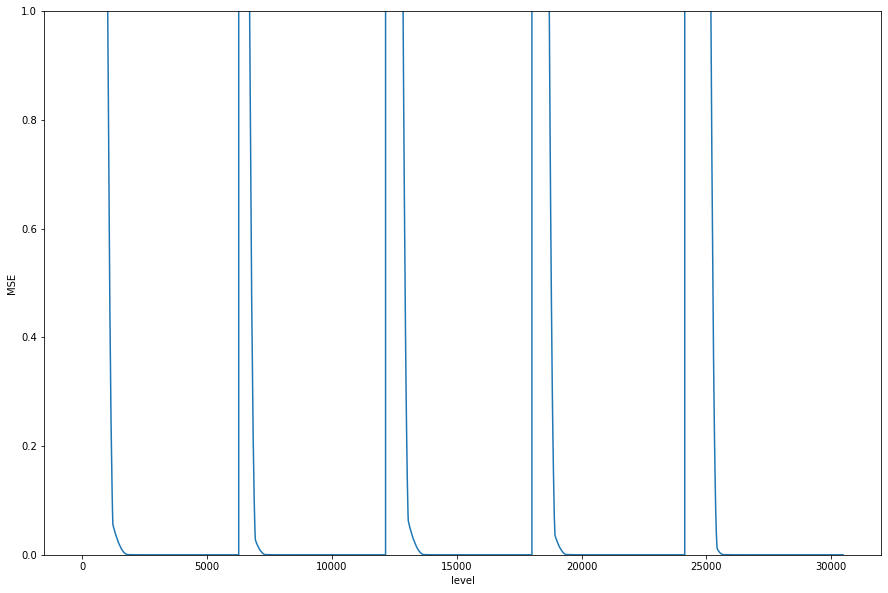

In [12]:
hill_climbing.progress.plot(x='level', y='MSE', ylim=(0, 1))

Solve it by Simulated Annealing:

In [13]:
simulated_annealing = SimulatedAnnealing(equation_system, min_range, max_range)

In [14]:
simulated_annealing.search()

current level:  69044 - current MSE: 2.017857e-27 - T: 9.990082e-31 - step: 1.000000e-13


MSE: 9.215656223216286e-28
answer vector:
[[  962.46186593]
 [  224.58257976]
 [ -316.52966465]
 [ -362.45043891]
 [ -358.78457136]
 [  331.59497287]
 [  -64.51958532]
 [  466.90700277]
 [-1102.79632199]
 [  509.6873785 ]]

MSE graph by level:

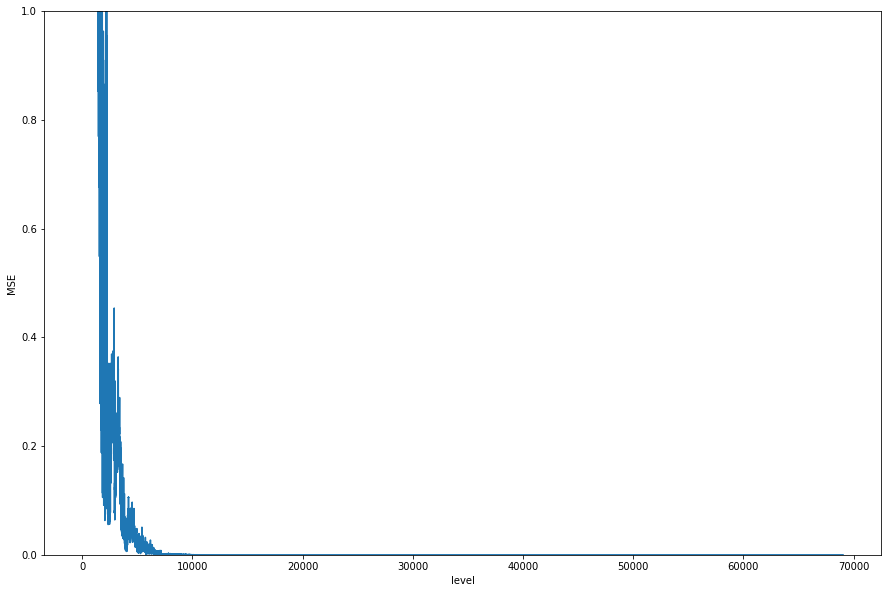

In [15]:
simulated_annealing.progress.plot(x='level', y='MSE', ylim=(0, 1))

$log(T)$ graph by level:

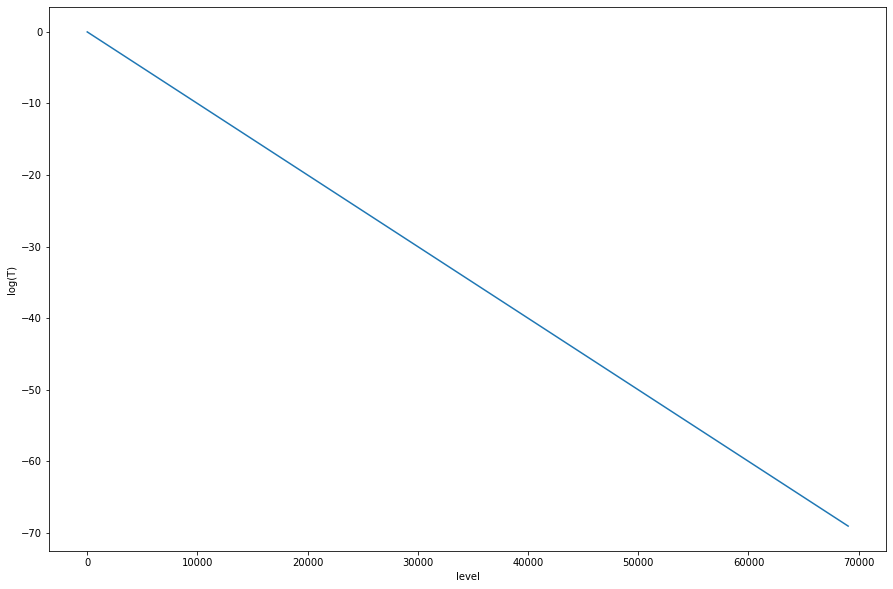

In [16]:
simulated_annealing.progress.plot(x='level', y='log(T)')

MSE graph by $log(T)$:

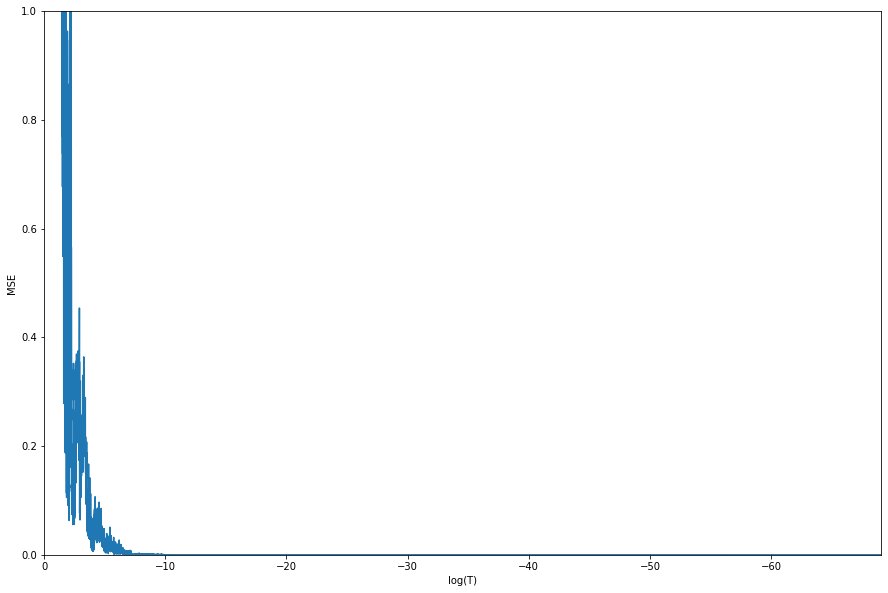

In [17]:
simulated_annealing.progress.plot(x='log(T)', y='MSE', invert=True, ylim=(0,1))

The results from the Hill Climbing algorithm have an MSE in the orther of $10^{-23}$, while the results for the Simulated Annealing algorithm is in the orther of $10^{-28}$.

Also, in the Hill Climbing algorithm, we have to run the algorithm several times (random restart) to get the most optimal mode possible. While the Simulated Annealing algorithm achieves its best with a single run, due to random movements.

These results were not unexpected, as the Simulated Annealing algorithm is a kind of evolution of the Hill Climbing algorithm, and due to the occasional randomness, as shown in the animation below, it can escape the traps of local minimalists.

![](SimulatedAnnealing.gif)